2.7.0
351


100%|██████████| 10/10 [00:01<00:00,  5.25it/s]


(28, 28)
149
234
344
95
338
86
52
214
91
160
234
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 16)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 16)        2320      
                                                                 
 dropout (Dropout)           (None, 22, 22, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 32)          0         
       

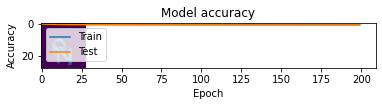

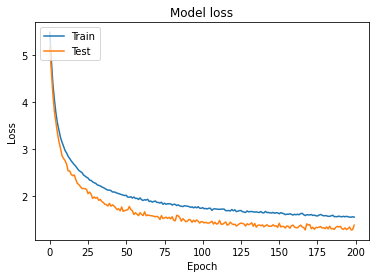

126/126 [==============================] - 1s 11ms/step - loss: 1.3799 - accuracy: 0.6357
1.3798885345458984
0.6356858611106873
(1, 28, 28, 1)


ValueError: ignored

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from sklearn.model_selection import train_test_split
from keras.utils import np_utils

print(tf.__version__)

CATEGORIES = sorted(list(os.listdir("/content/drive/MyDrive/OCR For Gujarati Language/Dataset/Gujarati Characters Dataset Photos/28x28")))
IMG_SIZE = 64
training_data = []
print(len(CATEGORIES))

IMG_SIZE = 28

#%%
#create training data
training_data = []

def create_training_data(DATADIR):
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)  # create path to dataset
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):  # iterate over each image per alphbets
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                img = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  #size to normalize data size
                """for i in range(len(img)):
                    for j in range(len(img[0])):
                        img[i][j] = 255 - img[i][j]"""
                training_data.append([img, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))
            
#loading data from dataset  folders
create_training_data("/content/drive/MyDrive/OCR For Gujarati Language/Dataset/Gujarati Characters Dataset Photos/28x28")

pickle_out = open("GujaratiData.pickle","wb")
pickle.dump(training_data, pickle_out)
pickle_out.close()

#loading data from pickle file
pickle_in = open("GujaratiData.pickle","rb")
training_data = pickle.load(pickle_in)

print(training_data[0][0].shape)


#randomize data
random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])

X = []
Y = []

for features,label in training_data:
    X.append(features)
    Y.append(label)

#print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE)
Y = np.array(Y).reshape(X.shape[0],)

seed = 785

# split the data into training (80%) and testing (20%)
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.20, random_state=seed)
print(Y[1])

X_train = X_train.reshape(X_train.shape[0], IMG_SIZE, IMG_SIZE, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], IMG_SIZE, IMG_SIZE, 1).astype('float32')

X_train = X_train / 255
X_test = X_test / 255

# one hot encode outputs
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)

num_classes = Y_test.shape[1]

plt.imshow((tf.squeeze(X_train[0])))
X_train[0].shape

#%%
#model training
model = Sequential()


model.add(Conv2D(filters=16, kernel_size=5, input_shape=(IMG_SIZE,IMG_SIZE,1), activation='relu'))
model.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=3, strides=2))
     
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))
      
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(Dropout(0.3))
       
model.add(MaxPooling2D(pool_size=3, strides=2))
       
model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())    
model.add(Dense(units=500))
model.add(Dropout(0.5))
       
model.add(Dense(num_classes, activation='softmax'))
        
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
#%%
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200, batch_size=64, verbose=2)


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#%%
#model evaluation
val_loss, val_acc = model.evaluate(X_test, Y_test)
print(val_loss)
print(val_acc)


#%%
# Visualizing the intermediate layer

#
from keras import backend as K
test_image = X_test[0:1]
print (test_image.shape)
def get_featuremaps(model, layer_idx, X_batch):
	get_activations = K.function([model.layers[0].input, K.learning_phase()],[model.layers[layer_idx].output,])
	activations = get_activations([X_batch,0])
	return activations

layer_num=0
filter_num=0

activations = get_featuremaps(model, int(layer_num),test_image)

print (np.shape(activations))
feature_maps = activations[0][0]      
print (np.shape(feature_maps))

if K.common.image_dim_ordering()=='th':
	feature_maps=np.rollaxis((np.rollaxis(feature_maps,2,0)),2,0)
print (feature_maps.shape)

fig=plt.figure(figsize=(16,16))
plt.imshow(feature_maps[:,:,filter_num],cmap='gray')
# plt.savefig("featuremaps-layer-{}".format(layer_num) + "-filternum-{}".format(filter_num)+'.bmp')

num_of_featuremaps=feature_maps.shape[2]
fig=plt.figure(figsize=(16,16))	
plt.title("featuremaps-layer-{}".format(layer_num))
subplot_num=int(np.ceil(np.sqrt(num_of_featuremaps)))
for i in range(int(num_of_featuremaps)):
	ax = fig.add_subplot(subplot_num, subplot_num, i+1)
	#ax.imshow(output_image[0,:,:,i],interpolation='nearest' ) #to see the first filter
	ax.imshow(feature_maps[:,:,i],cmap='gray')
	plt.xticks([])
	plt.yticks([])
	plt.tight_layout()
plt.show()
# fig.savefig("featuremaps-layer-{}".format(layer_num) + '.bmp')



# Printing the confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(X_test)
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
#y_pred = model.predict_classes(X_test)
#print(y_pred)
#trget_names = ['class 0(cats)', 'class 1(Dogs)', 'class 2(Horses)','class 3(Humans)']
					
# int(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=CATEGORIES)
print(classification_report(np.argmax(Y_test, axis=1), y_pred, target_names=CATEGORIES))

print(confusion_matrix(np.argmax(Y_test,axis=1), y_pred))


# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))

print("confusion matrix:\n", cnf_matrix) 

np.set_printoptions(precision=2)

plt.figure()


plt.show()
#save the model
model.save('GujaratiOCRModel')
#load saved model
new_model = tf.keras.models.load_model('GujaratiOCRModel')

#predict image on test data
predictions = new_model.predict(X_test)

print(CATEGORIES[np.argmax(predictions[160])])

img = cv2.resize(X_test[160], (28,28))

plt.imshow(img)

#%%
np.argmax(Y_test, axis=1)
